# Setting Up

## Install Dependencies

In [35]:
! pip install catboost
! pip install shap
! pip install captum
!pip install dowhy
!apt-get install -y graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


# Import libraries

In [36]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from lightgbm import LGBMRegressor
from torch.utils.data import DataLoader, TensorDataset
from catboost import CatBoostRegressor
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN


import shap
from sklearn.metrics import matthews_corrcoef
from captum.attr import IntegratedGradients
import numpy as np
from hyperopt import hp


# EDA

## Import Data

In [37]:
# EDA
train = pd.read_csv("data/train.csv")
test=pd.read_csv("data/test.csv")
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


## Explore Data

In [38]:
## Shape
print(f"Shape: {train.shape}\n","="*40)
## Missing Values
print(f"Missing Values:\n{train.isnull().sum()}\n","="*40)
## Summary Stats
print(f"Summary Stats: \n{train.describe()}\n","="*40)
## Cardinality
print(f'Cardinality: {len(train["uniqueid"].unique())}')


Shape: (23524, 13)
Missing Values:
country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64
Summary Stats: 
               year  household_size  age_of_respondent
count  23524.000000    23524.000000       23524.000000
mean    2016.975939        3.797483          38.805220
std        0.847371        2.227613          16.520569
min     2016.000000        1.000000          16.000000
25%     2016.000000        2.000000          26.000000
50%     2017.000000        3.000000          35.000000
75%     2018.000000        5.000000          49.000000
max     2018.000000       21.000000         100.000000
Cardinality: 8735


In [39]:
# Info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


## Preprocessing

In [40]:
# PreProcessing
# Concat train and test sets
test["test"]=True
train["test"]=False
y = train["bank_account"]
train.drop(columns=["bank_account"],inplace=True)
train.head(3)
df = pd.concat([train,test])
df.head()

# Drop unique id
df.drop(columns=["uniqueid"],inplace=True)

# Transform Features
## Transform Country
"""
- sparse_output=False: Return regular 2D Array
- set_output: Return DF instead of numpy array
"""
enc = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
country_transform = enc.fit_transform(df[['country']])

# Convert the one-hot encoded columns to integers
country_transform = country_transform.astype(int)
df = pd.concat([df,country_transform],axis=1).drop(columns=["country"])

## Transform Location Type
df['urban']= [1 if location == "Urban" else 0 for location in df['location_type']]
df.drop('location_type',axis=1,inplace=True)

## Transform Gender
df['male']=[1 if gender.lower() == 'male' else 0 for gender in df['gender_of_respondent']]
df.drop('gender_of_respondent',axis=1,inplace=True)

## Transform Cellphone Access
df['cellphone_access'] = [1 if cellphone.lower() == 'yes' else 0 for cellphone in df['cellphone_access']]

## Transform Relationship with head
enc = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
relationship_transform = enc.fit_transform(df[['relationship_with_head']])
relationship_transform = relationship_transform.astype(int)
df = pd.concat([df,relationship_transform],axis=1).drop(columns=["relationship_with_head"])

## Transform marital_status
df['marital_status'].unique()
enc = OneHotEncoder(handle_unknown='ignore',sparse_output=False).set_output(transform='pandas')
marital_status_transform = enc.fit_transform(df[['marital_status']])
marital_status_transform = marital_status_transform.astype(int)
df = pd.concat([df,marital_status_transform],axis=1).drop(columns=["marital_status"])

## Transform Education Level
enc = OneHotEncoder(handle_unknown='ignore',sparse_output=False).set_output(transform='pandas')
education_level_transform = enc.fit_transform(df[['education_level']])
education_level_transform = education_level_transform.astype(int)
df = pd.concat([df,education_level_transform],axis=1).drop(columns=["education_level"])

## Transform Job Type
enc = OneHotEncoder(handle_unknown='ignore',sparse_output=False).set_output(transform='pandas')
job_type_transform = enc.fit_transform(df[['job_type']]).astype(int)
df = pd.concat([df,job_type_transform],axis=1).drop(columns=["job_type"])


## Transform Target
y = [1 if bank.lower() == "yes" else 0 for bank in y]

df.head().T



,0,1,2,3,4
year,2018,2018,2018,2018,2018
cellphone_access,1,0,1,1,0
household_size,3,5,5,5,8
age_of_respondent,24,70,26,34,26
test,False,False,False,False,False
country_Kenya,1,1,1,1,1
country_Rwanda,0,0,0,0,0
country_Tanzania,0,0,0,0,0
country_Uganda,0,0,0,0,0
urban,0,0,1,0,1


## Class Balance

In [41]:
# Calculate the total number of elements in the list
total_elements = len(y)

# Count the occurrences of 1s and 0s
count_ones = y.count(1)
count_zeros = y.count(0)

# Calculate the percentage of 1s and 0s
percentage_ones = (count_ones / total_elements) * 100
percentage_zeros = (count_zeros / total_elements) * 100

# Print the results
print(f"Percentage of 1s: {percentage_ones:.2f}%")
print(f"Percentage of 0s: {percentage_zeros:.2f}%")



Percentage of 1s: 14.08%
Percentage of 0s: 85.92%


## Train Test Split

In [42]:
# Train Test Validation Split
# Train Set
df_train = df.where(df['test']==False).dropna().drop('test',axis=1)
# Test Set
df_test = df.where(df['test']==True).dropna().drop('test',axis=1)
# Splitting the data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.05, stratify=y)
X_train.head()
# Oversampling / Oversampling  Combo
# sampler = SMOTEENN(random_state=42)
# X_train, y_train = sampler.fit_resample(X_train, y_train)

# Training and Evaluation
## Training

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Training

## Hyper Paramter Search Space

In [43]:
# Random Forest hyperparameter space with simplified parameter handling
rf_space = {
    'n_estimators': hp.quniform('n_estimators', 10, 2000, 1),
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    # For percentage-based options, use float < 1.0
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 0.9),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.9),
    'max_features': hp.uniform('max_features', 0.1, 1.0)
}

# LightGBM hyperparameter space
lgbm_space = {
    'n_estimators': hp.quniform('n_estimators', 10, 2000, 1),
    'max_depth': hp.quniform('max_depth', 1, 20, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(0.5)),
    'num_leaves': hp.quniform('num_leaves', 2, 100, 1),
    'min_child_samples': hp.quniform('min_child_samples', 1, 100, 1),
    'subsample': hp.uniform('subsample', 0.1, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'lambda_l1': hp.loguniform('lambda_l1', np.log(1e-8), np.log(10.0)),
    'lambda_l2': hp.loguniform('lambda_l2', np.log(1e-8), np.log(10.0))
}

# CatBoost hyperparameter space
catboost_space = {
    'iterations': hp.quniform('iterations', 10, 2000, 1),
    'depth': hp.quniform('depth', 1, 16, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(0.5)),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', np.log(1e-8), np.log(10.0)),
    'random_strength': hp.uniform('random_strength', 1e-8, 10.0),
    'bagging_temperature': hp.uniform('bagging_temperature', 0.0, 1.0),
    'border_count': hp.quniform('border_count', 32, 255, 1),
    'subsample': hp.uniform('subsample', 0.1, 1.0)
}

def objective(params, model_class, X_train, y_train, X_test, y_test):
    # Convert necessary parameters to integers
    processed_params = params.copy()

    # Integer parameters
    int_params = ['n_estimators', 'num_leaves', 'min_child_samples',
                  'iterations', 'depth', 'border_count']

    for param in int_params:
        if param in processed_params:
            processed_params[param] = int(processed_params[param])

    # Handle max_depth
    if 'max_depth' in processed_params:
        processed_params['max_depth'] = int(processed_params['max_depth']) if processed_params['max_depth'] >= 1 else None

    # Create and fit model
    if model_class == RandomForestRegressor:
        # For Random Forest, ensure min_samples_leaf and min_samples_split are floats between 0 and 1
        processed_params['min_samples_leaf'] = float(processed_params['min_samples_leaf'])
        processed_params['min_samples_split'] = float(processed_params['min_samples_split'])
        model = model_class(**processed_params, random_state=42)
    elif model_class == LGBMRegressor:
        model = model_class(**processed_params, force_col_wise=True, verbose=-1)
    elif model_class == CatBoostRegressor:
        model = model_class(**processed_params, silent=True)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return {'loss': mae, 'status': STATUS_OK}


## Optimization calls


In [44]:

# Random Forest

rf_best = fmin(
    fn=lambda params: objective(params, RandomForestRegressor, X_train_scaled, y_train, X_test_scaled, y_test),
    space=rf_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)




100%|██████████| 50/50 [01:26<00:00,  1.73s/trial, best loss: 0.2239458584260315]


In [45]:
# LGBM
lgbm_best = fmin(
    fn=lambda params: objective(params, LGBMRegressor, X_train_scaled, y_train, X_test_scaled, y_test),
    space=lgbm_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)



100%|██████████| 50/50 [01:08<00:00,  1.36s/trial, best loss: 0.16985732957802316]


In [46]:
# CatBoost
catboost_best = fmin(
    fn=lambda params: objective(params, CatBoostRegressor, X_train_scaled, y_train, X_test_scaled, y_test),
    space=catboost_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

100%|██████████| 50/50 [20:18<00:00, 24.36s/trial, best loss: 0.17136170601664866]


## Deep Neural Network

In [47]:
# PyTorch Deep Learning Model
class ImprovedNN(nn.Module):
    def __init__(self, input_size):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return x

# Convert data to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train_scaled).float(), torch.tensor(y_train).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# PyTorch model setup
model = ImprovedNN(input_size=X_train_scaled.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Training loop
epochs = 50
for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
    scheduler.step()

# Evaluate the deep learning model
model.eval()
with torch.no_grad():
    y_pred_nn = model(torch.tensor(X_test_scaled).float()).squeeze().numpy()

mae_nn = mean_absolute_error(y_test, y_pred_nn)



## Retrieve Best Parameters and Model Training

In [48]:
# Retrieve the best hyperparameters
best_rf_params = space_eval(rf_space, rf_best)
best_lgbm_params = space_eval(lgbm_space, lgbm_best)
best_catboost_params = space_eval(catboost_space, catboost_best)

# Ensure max_depth and n_estimators are integers for RandomForestRegressor
if 'max_depth' in best_rf_params:
    best_rf_params['max_depth'] = int(round(best_rf_params['max_depth']))
if 'n_estimators' in best_rf_params:
    best_rf_params['n_estimators'] = int(round(best_rf_params['n_estimators']))

# Ensure integer parameters for LightGBM
for param in ['n_estimators', 'num_leaves', 'max_depth', 'min_child_samples']:
  best_lgbm_params[param] = int(round(best_lgbm_params[param]))

# Refit models with the best parameters
best_rf_model = RandomForestRegressor(**best_rf_params, random_state=42)
best_rf_model.fit(X_train_scaled, y_train)
y_pred_rf = best_rf_model.predict(X_test_scaled)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

best_lgbm_model = LGBMRegressor(**best_lgbm_params, force_col_wise=True, verbose=-1)
best_lgbm_model.fit(X_train_scaled, y_train)
y_pred_lgbm = best_lgbm_model.predict(X_test_scaled)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)

best_catboost_model = CatBoostRegressor(**best_catboost_params, silent=True)
best_catboost_model.fit(X_train_scaled, y_train)
y_pred_catboost = best_catboost_model.predict(X_test_scaled)
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)



# Results

## Mean Absolut Error

In [49]:
# Display the MAE results
mae_scores = {
    'random_forest': mae_rf,
    'lightgbm': mae_lgbm,
    'catboost': mae_catboost,
    'dnn':mae_nn
}

df_mae = pd.DataFrame.from_dict(mae_scores, orient='index', columns=['MAE'])
print(df_mae)

                    MAE
random_forest  0.223946
lightgbm       0.169857
catboost       0.171362
dnn            0.179347


# Explainability


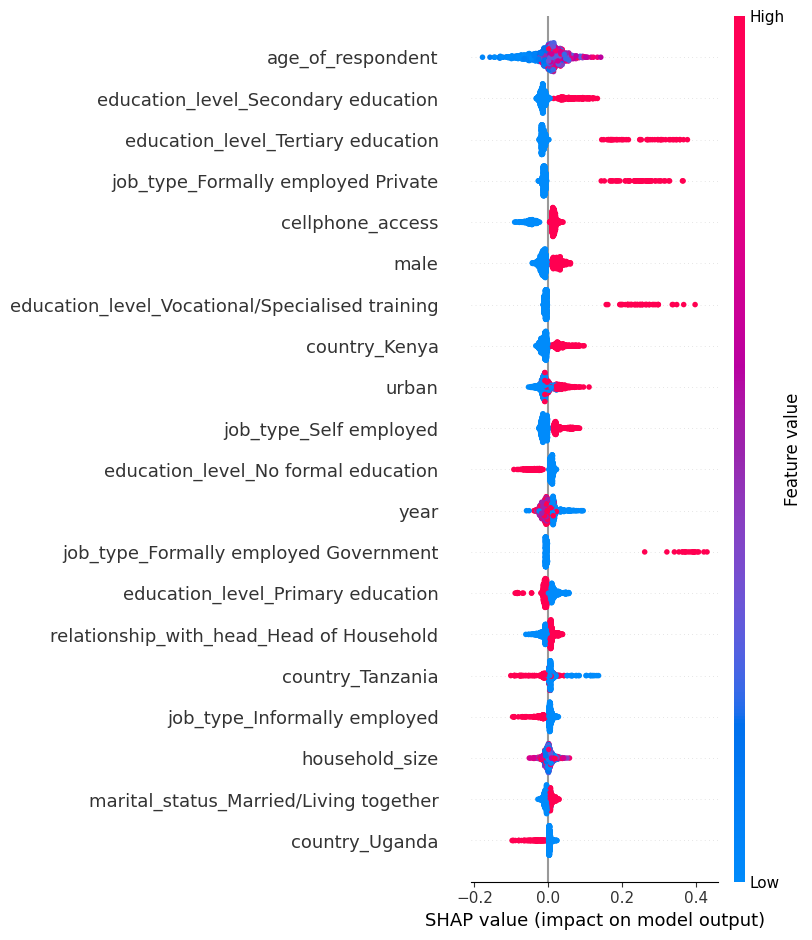

                    MAE
random_forest  0.223946
lightgbm       0.169857
catboost       0.171362
pytorch_nn     0.179347


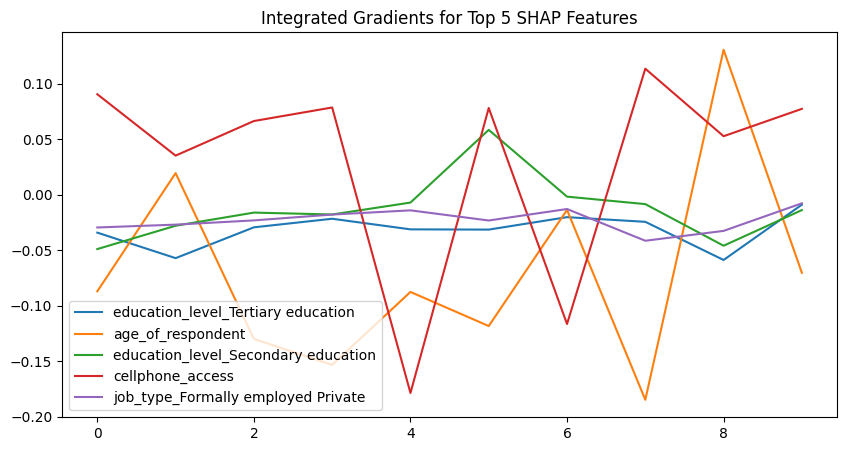

In [53]:
# Explainability
## SHAP
 # SHAP for LightGBM
# Create an explainer object for LightGBM
explainer = shap.Explainer(best_lgbm_model)
# Calculate SHAP values for the test set
shap_values = explainer(X_test_scaled)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=df_train.columns)

# Compute Matthews Correlation Coefficient (MCC) for LightGBM
y_pred_lgbm_binary = (y_pred_lgbm > 0.7).astype(int)  # Thresholding for binary output
mcc_lgbm = matthews_corrcoef(y_test, y_pred_lgbm_binary)

# Compute MCC for Random Forest
y_pred_rf_binary = (y_pred_rf > 0.8).astype(int)
mcc_rf = matthews_corrcoef(y_test, y_pred_rf_binary)

# Compute MCC for CatBoost
y_pred_catboost_binary = (y_pred_catboost > 0.8).astype(int)
mcc_catboost = matthews_corrcoef(y_test, y_pred_catboost_binary)

# Compute MCC for PyTorch NN
y_pred_nn_binary = (y_pred_nn > 0.8).astype(int)
mcc_nn = matthews_corrcoef(y_test, y_pred_nn_binary)
# Display the MAE and MCC results
performance_scores = {
    'random_forest': {'MAE': mae_rf},
    'lightgbm': {'MAE': mae_lgbm},
    'catboost': {'MAE': mae_catboost},
    'pytorch_nn': {'MAE': mae_nn}
}

df_performance = pd.DataFrame(performance_scores).T
print(df_performance)
## Integratged Gradients
# Top 5 features are obtained from SHAP analysis
top_5_features = ['education_level_Tertiary education', 'age_of_respondent',
                  'education_level_Secondary education', 'cellphone_access',
                  'job_type_Formally employed Private']

# Get the indices of these top 5 features in the dataset
top_5_feature_indices = [df_train.columns.get_loc(feature) for feature in top_5_features]

# Compute Integrated Gradients on the full feature set
X_test_tensor = torch.tensor(X_test_scaled).float()
ig = IntegratedGradients(model)

# Define a baseline (e.g., zeroes)
baseline = torch.zeros(X_test_tensor.shape).float()

# Compute attributions using Integrated Gradients for the entire dataset
attributions_ig = ig.attribute(X_test_tensor, baselines=baseline)

# Convert the attributions to numpy for plotting
attributions_ig_np = attributions_ig.detach().numpy()

# Extract only the attributions for the top 5 SHAP features
attributions_ig_top_5 = attributions_ig_np[:, top_5_feature_indices]

# Plot Integrated Gradients for the top 5 SHAP features
plt.figure(figsize=(10, 5))
plt.title("Integrated Gradients for Top 5 SHAP Features")
for i, feature in enumerate(top_5_features):
    plt.plot(attributions_ig_top_5[:10, i], label=feature)  # Plotting for the first 10 samples
plt.legend()
plt.show()